# Provided Code

In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

TensorFlow 2.x selected.
2.1.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# helper functions for visualisation
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [6]:
# Load the data: CIFAR100 with 20 class labels
(x_train_all, r_train_all_class), ( _ , _ ) = cifar100.load_data(label_mode='coarse')

num_classes = 20

# let's again take a subset of the training data first, for playing around
# Note that such a subset is only useful if it can guide your tuning process,
# i.e., if it leads you to similar decisions as you would make on the whole training set

# And we do the same standardization as in the first assignment
x_train_all = x_train_all.astype('float32')

x_train_all /= 255.0

# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_train_all = to_categorical(r_train_all_class, num_classes)


# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_train_all shape:', x_train_all.shape)

x_train_all shape: (50000, 32, 32, 3)


# ConvNet

In [0]:
# Then, add regularization
def regularized_model(learning_rate=0.001):
  model = Sequential([
    # 1
    Conv2D(64, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm(), input_shape=(32,32,3)),
    BatchNormalization(momentum=0.95),
    Activation('relu'),
    
    # 2
    Conv2D(64, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm()),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # First Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 3
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm()),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 4
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm()),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # Second Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    # 5
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm()),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # 6
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm()),
    BatchNormalization(momentum=0.95),
    Activation('relu'),

    # Third Maxpooling
    MaxPooling2D(pool_size=(2,2), strides=2),

    Flatten(),
    # Dropout
    Dropout(0.25),
    Dense(num_classes),
    Activation('softmax')
  ])

  opt = Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model

In [13]:
# train on all data
model = regularized_model(learning_rate=0.0005)
model.summary()

batch_size=256
epochs=50

# data augmentation
datagen = ImageDataGenerator(
        # rotation_range=22.5,
        # width_shift_range=0.25,
        # height_shift_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

history = model.fit(datagen.flow(x_train_all, r_train_all, batch_size=batch_size),
          epochs=epochs,
          shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0

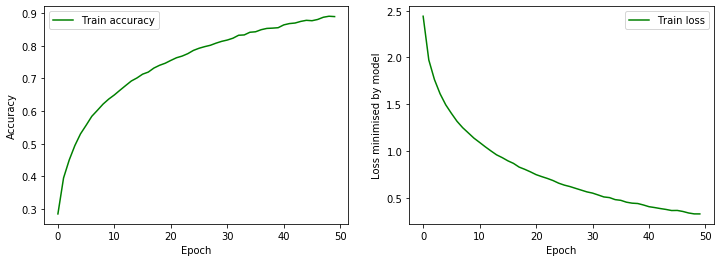

In [14]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history.epoch, np.array(history.history['loss']),'g-',
        label='Train loss')
plt.legend()

In [15]:
# the file type for storing complete models is ".h5"
# feel free to change the path to whatever suits you best!
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2020/GA2/"
modelpath = checkpoint_dir+"convnet.h5"
print("Final model saved as ",modelpath)

# Save entire model to a HDF5 file
model.save(modelpath)

Final model saved as  /content/gdrive/My Drive/Colab Notebooks/DL2020/GA2/convnet.h5


In [16]:
# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = model.evaluate(x_train_all, r_train_all, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

Training set Accuracy:   0.92
Training set Loss: 0.2436



# ResNet

In [0]:
# using skip connections
def residual_model(learning_rate=0.001):
  img_input = Input(shape=(32,32,3))

  # 1
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm())(img_input)
  x = BatchNormalization(momentum=0.95)(x)
  xskip = Activation('elu')(x)
  
  # 2
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm())(xskip)
  x = BatchNormalization(momentum=0.95)(x)
  x = Activation('elu')(x)

  # 3
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm())(x)
  x = BatchNormalization(momentum=0.95)(x)

  # First skip connection
  x = Add()([x, xskip])
  x = Activation('elu')(x)

  # First Maxpooling
  xskip = MaxPooling2D(pool_size=(2,2), strides=2)(x)

  # 4
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm())(xskip)
  x = BatchNormalization(momentum=0.95)(x)
  x = Activation('elu')(x)

  # 5
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm())(x)
  x = BatchNormalization(momentum=0.95)(x)

  # Second skip connection
  x = Add()([x, xskip])
  x = Activation('elu')(x)

  # Second Maxpooling
  xskip = MaxPooling2D(pool_size=(2,2), strides=2)(x)

  # 6
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm())(xskip)
  x = BatchNormalization(momentum=0.95)(x)
  x = Activation('elu')(x)

  # 7
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_constraint=MaxNorm())(x)
  x = BatchNormalization(momentum=0.95)(x)

  # Third skip connection
  x = Add()([x, xskip])
  x = Activation('elu')(x)

  # Third Maxpooling
  x = MaxPooling2D(pool_size=(2,2), strides=2)(x)

  x = Flatten()(x)
  # Dropout
  x = Dropout(0.25)(x)
  x = Dense(512, activation='elu', kernel_initializer='he_uniform', kernel_constraint=MaxNorm(), kernel_regularizer=l2(l=0.001))(x)
  x = Dense(256, activation='elu', kernel_initializer='he_uniform', kernel_constraint=MaxNorm(), kernel_regularizer=l2(l=0.001))(x)
  x = Dense(num_classes)(x)
  x = Activation('softmax')(x)

  # Create model
  model = Model(img_input, x)

  opt = Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

  return model

In [8]:
# retrain on all data
model = residual_model(learning_rate=0.0005)
model.summary()

batch_size=256
epochs=35

# data augmentation
datagen = ImageDataGenerator(
        # rotation_range=22.5,
        # width_shift_range=0.25,
        # height_shift_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

history = model.fit(datagen.flow(x_train_all, r_train_all, batch_size=batch_size),
          epochs=epochs,
          shuffle=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 128)  512         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 128)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

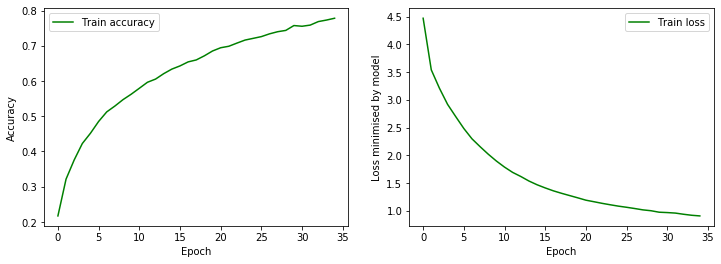

In [9]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history.epoch, np.array(history.history['loss']),'g-',
        label='Train loss')
plt.legend()

In [10]:
# the file type for storing complete models is ".h5"
# feel free to change the path to whatever suits you best!
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2020/GA2/"
modelpath = checkpoint_dir+"resnet.h5"
print("Final model saved as ",modelpath)

# Save entire model to a HDF5 file
model.save(modelpath)

Final model saved as  /content/gdrive/My Drive/Colab Notebooks/DL2020/GA2/resnet.h5


In [11]:
# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = model.evaluate(x_train_all, r_train_all, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

Training set Accuracy:   0.83
Training set Loss: 0.7527

